# Single cell RNAseq analysis human TILs

## Initialisation and reading data

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import scvelo as scv                              # RNA velocity toolkit
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
import scirpy as ir                               # TCR analysis

sc.settings.verbosity = 0                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                       # check if all needed versions are installed and up to date
results_file = './write/results.h5ad'             # the file that will store the analysis results

scanpy==1.4.3 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.1 pandas==1.1.5 scikit-learn==0.21.3 statsmodels==0.11.1 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 leidenalg==0.7.0


In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=200, color_map='viridis')

In [3]:
adata = sc.read_10x_mtx(
    "./GEX/outs/filtered_feature_bc_matrix/",
    var_names='gene_symbols',               
    cache=True, gex_only=False)                         
adata.var_names_make_unique()

## Demultiplex samples according to HTO antibodies

In [4]:
adata_HTO=adata[:, adata.var_names.isin(['Infusion_product','Blood_before','Blood_after'])]
sc.pp.normalize_per_cell(adata_HTO, counts_per_cell_after=1e4, min_counts=0)
sc.pp.log1p(adata_HTO)
sc.pp.scale(adata_HTO, max_value=10)
sc.tl.pca(adata_HTO)
sc.pp.neighbors(adata_HTO, n_neighbors=30, n_pcs=2)
sc.tl.umap(adata_HTO, spread=5, min_dist=1)
sc.tl.leiden(adata_HTO, resolution=0.1)

Trying to set attribute `.obs` of view, copying.


... storing 'feature_types' as categorical


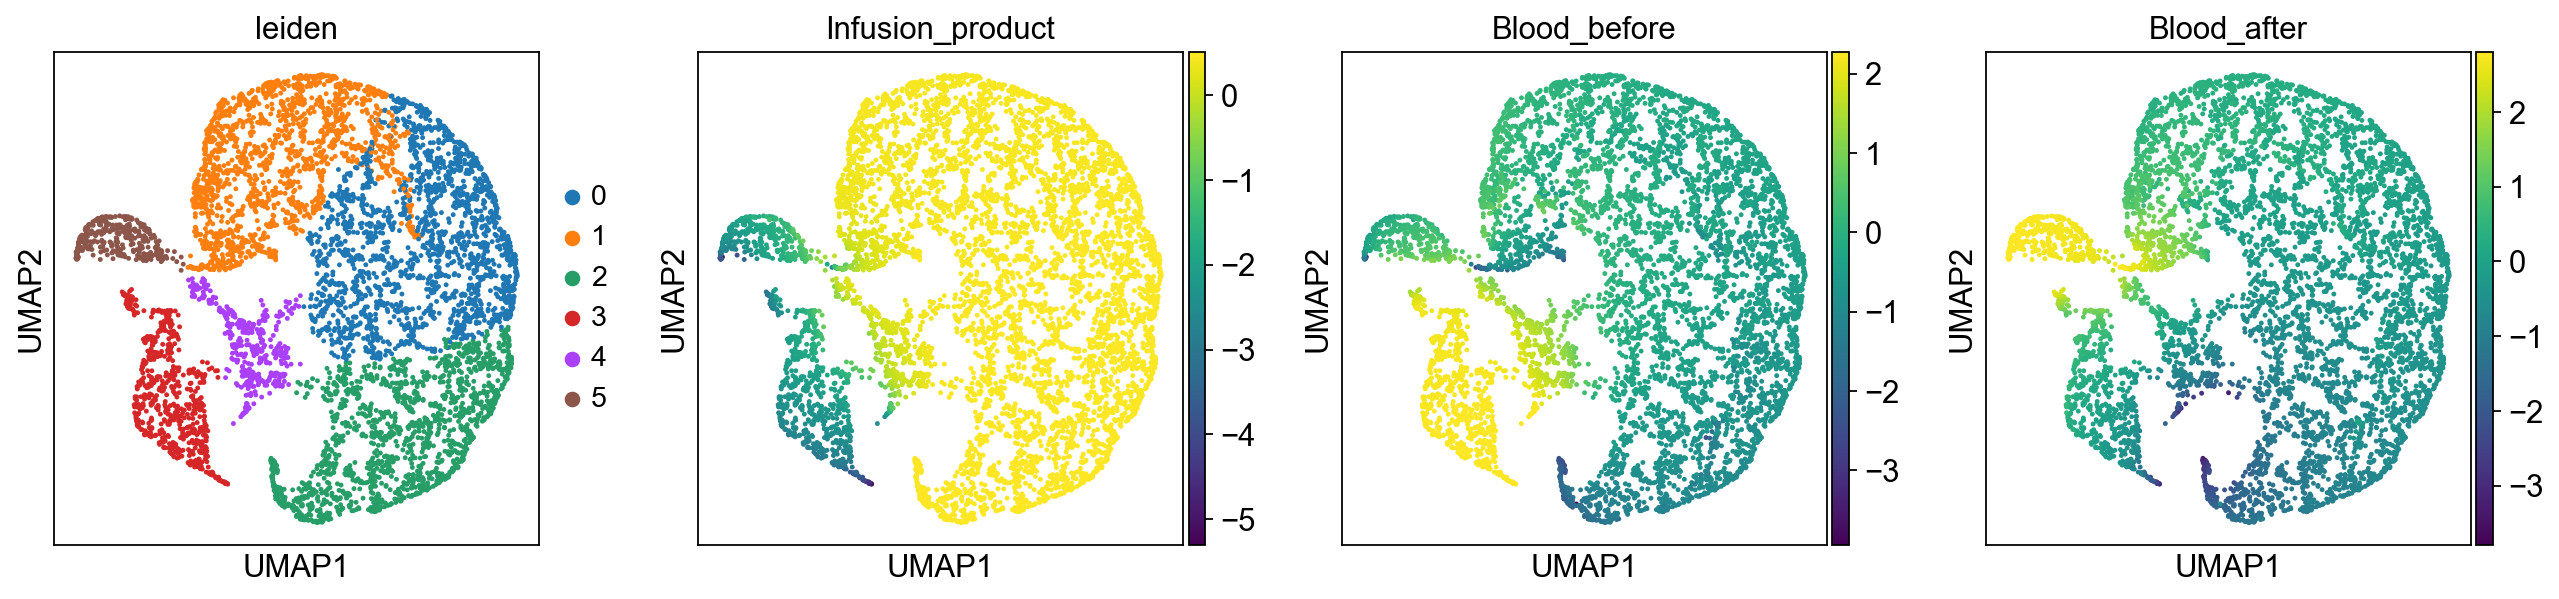

In [5]:
sc.pl.umap(adata_HTO, color=['leiden','Infusion_product','Blood_before','Blood_after'], save='_HTOs.pdf')

In [6]:
print('Barcoding efficacy: '+str((adata_HTO[~adata_HTO.obs.leiden.isin(['4'])].shape[0]/adata_HTO.shape[0])*100)[:4]+' %')
print('Cellnumber Infusion product: '+str(adata_HTO[adata_HTO.obs.leiden.isin(['0','1','2'])].shape[0]))
print('Cellnumber Blood before: '+str(adata_HTO[adata_HTO.obs.leiden.isin(['3'])].shape[0]))
print('Cellnumber Blood after: '+str(adata_HTO[adata_HTO.obs.leiden.isin(['5'])].shape[0]))

Barcoding efficacy: 94.0 %
Cellnumber Infusion product: 4857
Cellnumber Blood before: 649
Cellnumber Blood after: 323


In [7]:
adata=adata[:, ~adata.var_names.isin(['Infusion_product','Blood_before','Blood_after'])]
adata.obs['samplename']='None'
adata.obs.samplename[adata.obs_names.isin(adata_HTO[adata_HTO.obs.leiden.isin(['0','1','2'])].obs_names.tolist())]='Infusion_product'
adata.obs.samplename[adata.obs_names.isin(adata_HTO[adata_HTO.obs.leiden=='3'].obs_names.tolist())]='Blood_before'
adata.obs.samplename[adata.obs_names.isin(adata_HTO[adata_HTO.obs.leiden=='5'].obs_names.tolist())]='Blood_after'

adata=adata[adata.obs.samplename!='None']

Trying to set attribute `.obs` of view, copying.


## Preprocessing

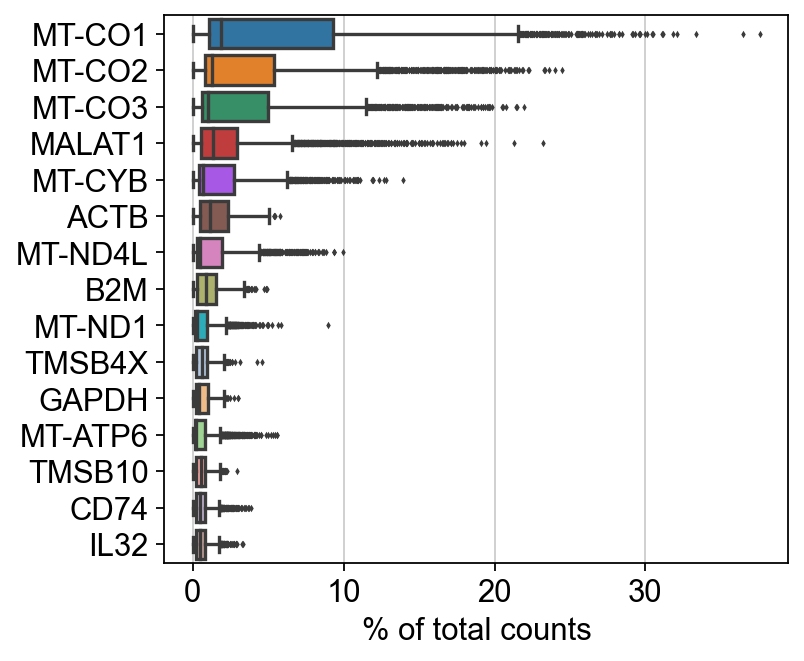

In [8]:
sc.pl.highest_expr_genes(adata, n_top=15)

Filter cells with less than 200 genes and genes that are present in less than 3 cells

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

ribo_genes = ((adata.var_names.str.startswith("RPL")) | (adata.var_names.str.startswith("RPS"))| (adata.var_names.str.startswith("MPL")))
adata.obs['percent_ribo'] = np.sum(
adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.var['ribo'] = ribo_genes

... storing 'samplename' as categorical
... storing 'feature_types' as categorical


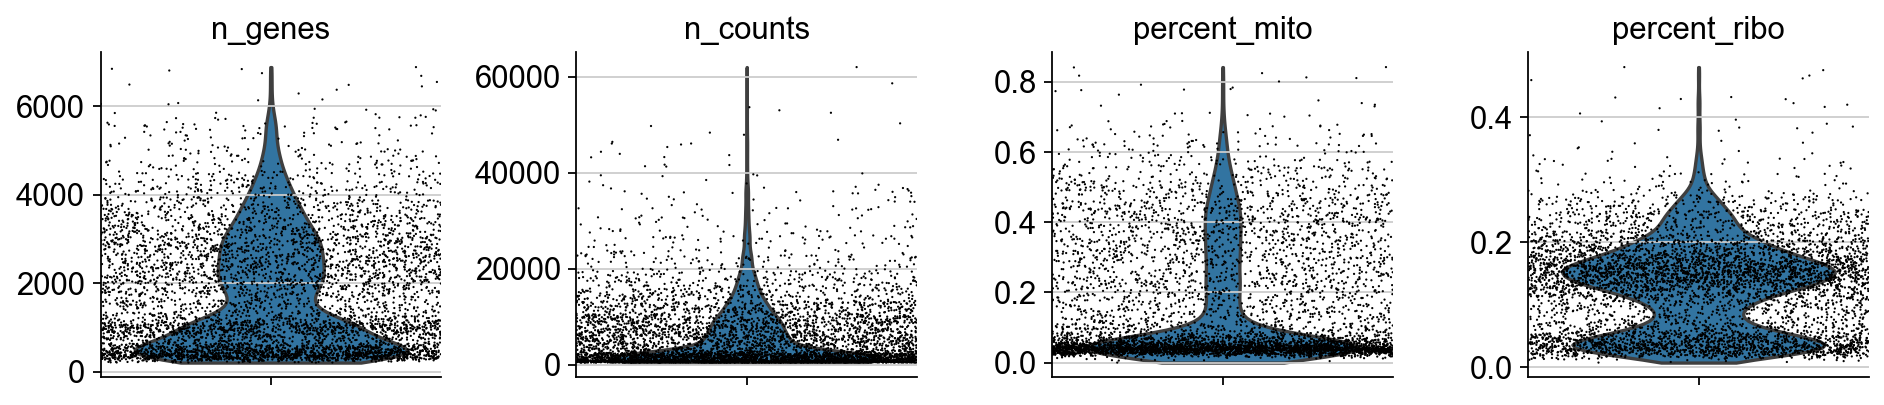

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
             jitter=0.5, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts. First, plot the counts versus the percentage of mitochondrial genes and versus the number of genes to define a threshold for later filtering.

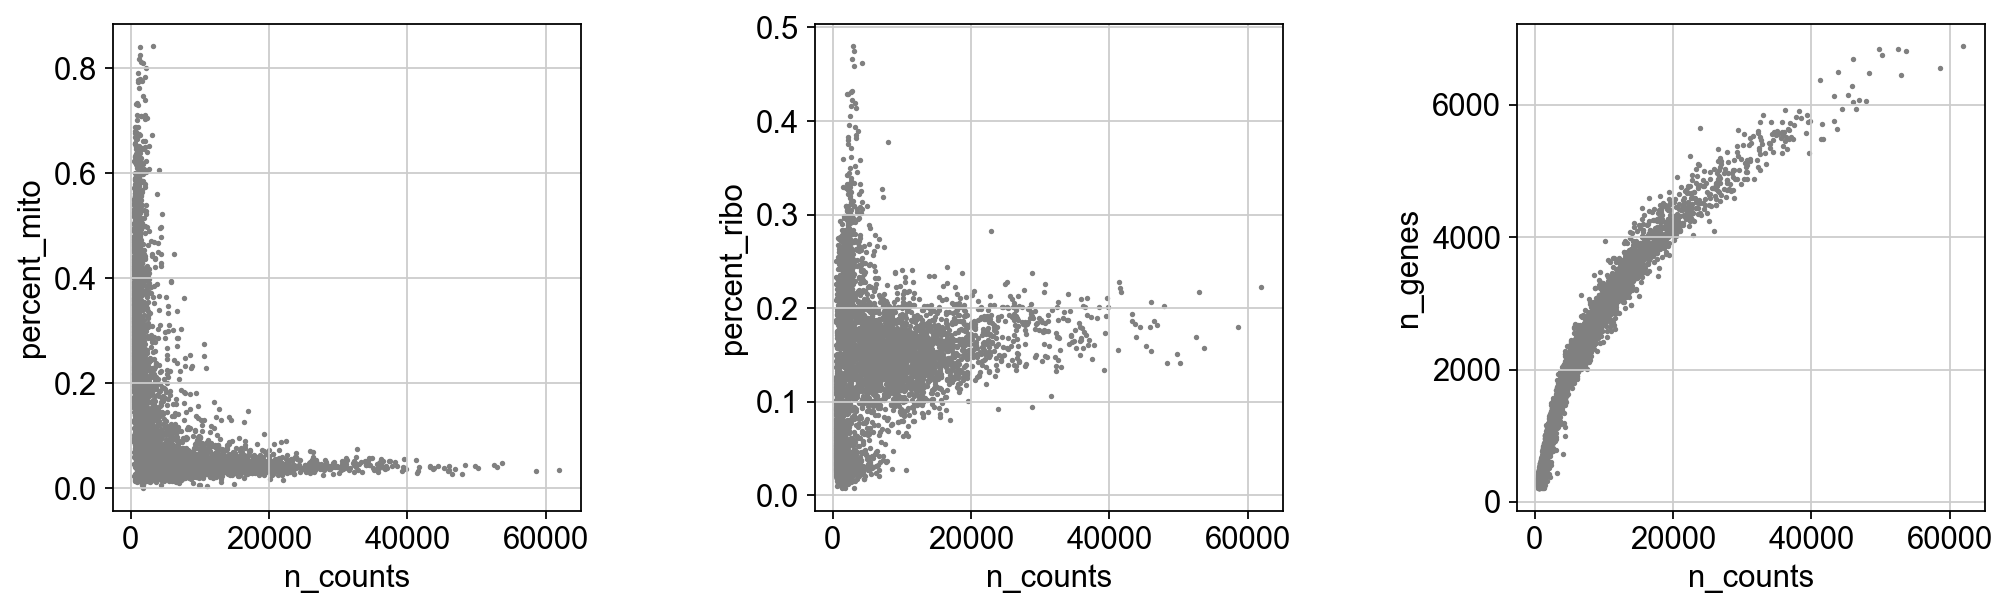

In [12]:
counts = adata.obs['n_counts']
mito = adata.obs['percent_mito']
genes = adata.obs['n_genes']
ribo = adata.obs['percent_ribo']
fig = plt.figure(figsize=(15, 4))
grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')
percent_mito.scatter(counts, mito, s=2, c='gray')
percent_ribo.scatter(counts, ribo, s=2, c='gray')
n_genes.scatter(counts, genes, s=2, c='gray')

In [13]:
counts_before=adata.n_obs
adata = adata[adata.obs['n_genes'] < 6000, :]
adata = adata[adata.obs['n_counts'] < 40000, :]
adata = adata[adata.obs['percent_mito'] < 0.4, :]

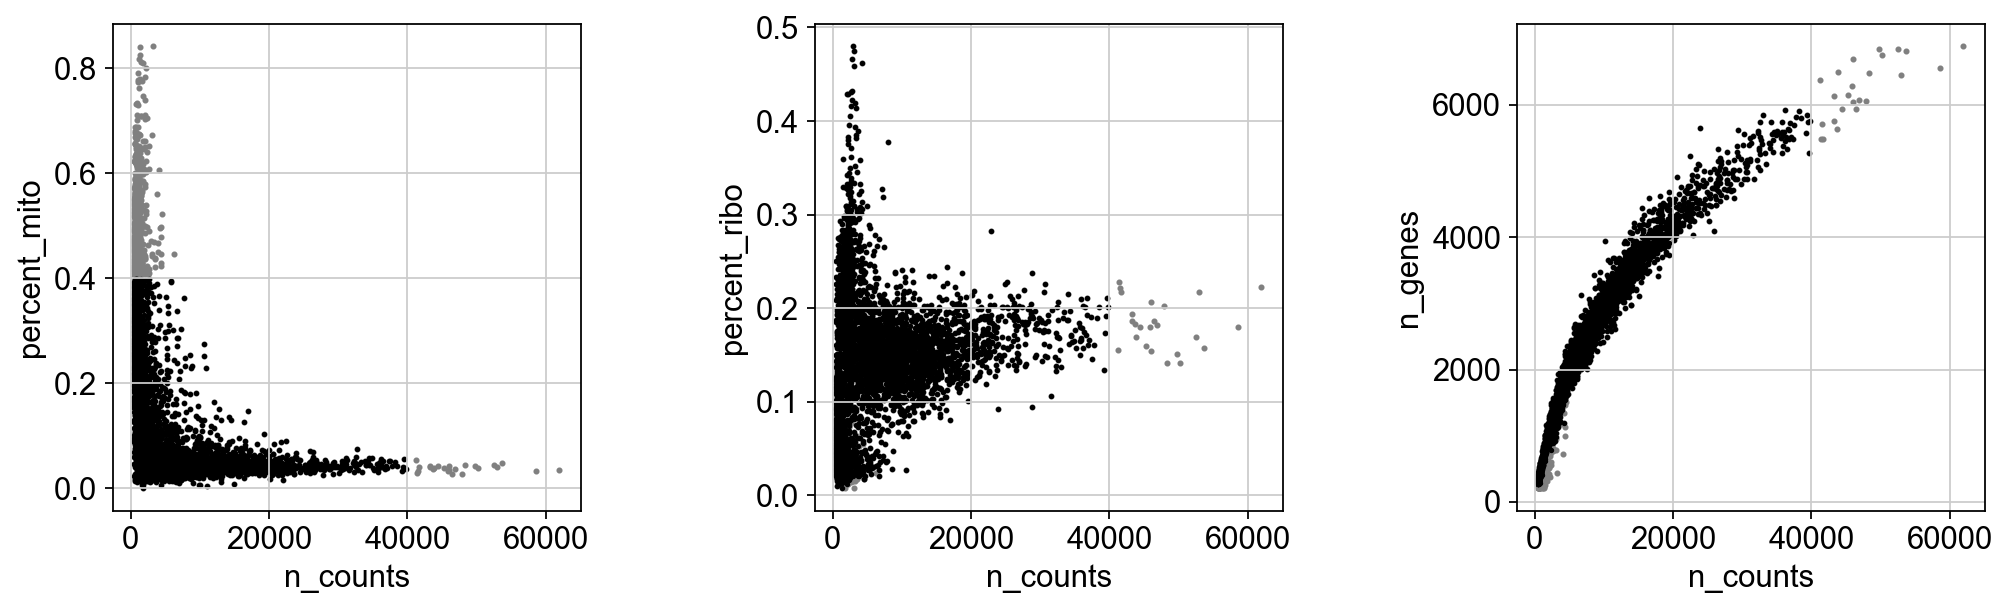

In [14]:
counts2 = adata.obs['n_counts']
mito2 = adata.obs['percent_mito']
genes2 = adata.obs['n_genes']
ribo2 = adata.obs['percent_ribo']

fig = plt.figure(figsize=(15, 4))
grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')

percent_mito.scatter(counts, mito, s=3, c='gray')
percent_ribo.scatter(counts, ribo, s=3, c='gray')
n_genes.scatter(counts, genes, s=3, c='gray')
percent_mito.scatter(counts2, mito2, s=2, c='black')
percent_ribo.scatter(counts2, ribo2, s=2, c='black')
n_genes.scatter(counts2, genes2, s=2, c='black')

fig.savefig('./figures/filtering.pdf', dpi=2000)

In [15]:
print(str(counts_before)+' --> '+str(adata.n_obs))

5671 --> 4849


In [16]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

Trying to set attribute `.obs` of view, copying.


In [17]:
exhaustion_genes=['HAVCR2','PDCD1','LAG3','EOMES','CD101','CD38','TIGIT']
sc.tl.score_genes(adata, exhaustion_genes, score_name='exhaustion_score')

activation_genes=['TNFRSF9','IFNG','TNF','GZMB','PRF1','NKG7','XCL1','XCL2','CCL3','CCL4','CCL5','CST7','STAT1','TGFB1']
sc.tl.score_genes(adata, activation_genes, score_name='activation_score')

naive_like_state_genes=['TCF7','CCR7','SELL','LEF1','IL7R']
predysfunctional_state_genes=['EOMES', 'GZMK', 'CXCR3']
dysfunctional_state_genes=['LAG3', 'PDCD1', 'LAYN', 'HAVCR2','CTLA4']
cytotoxic_state_genes=['KLRG1','PRF1','FCGR3A','CX3CR1']
cytotoxic_activation=['CCL5', 'GZMK', 'GNLY', 'EOMES', 'ZNF683','KLRG1', 'NKG7', 'ZEB2']
cytokine_activation=['CCL3', 'IFNG', 'CCL4', 'XCL1', 'XCL2', 'CSF2', 'IL10', 'HOPX', 'TIM3', 'LAG3', 'PRF1', 'TNFRSF9', 'NKG7', 'IL26']
sc.tl.score_genes(adata, naive_like_state_genes, score_name='naive_like_state')
sc.tl.score_genes(adata, predysfunctional_state_genes, score_name='predysfunctional_state')
sc.tl.score_genes(adata, dysfunctional_state_genes, score_name='dysfunctional_state')
sc.tl.score_genes(adata, cytotoxic_state_genes, score_name='cytotoxic_state')
sc.tl.score_genes(adata, dysfunctional_state_genes, score_name='cytotoxic_activation')
sc.tl.score_genes(adata, cytotoxic_state_genes, score_name='cytokine_activation')

## Cell cycle scoring

... storing 'phase' as categorical


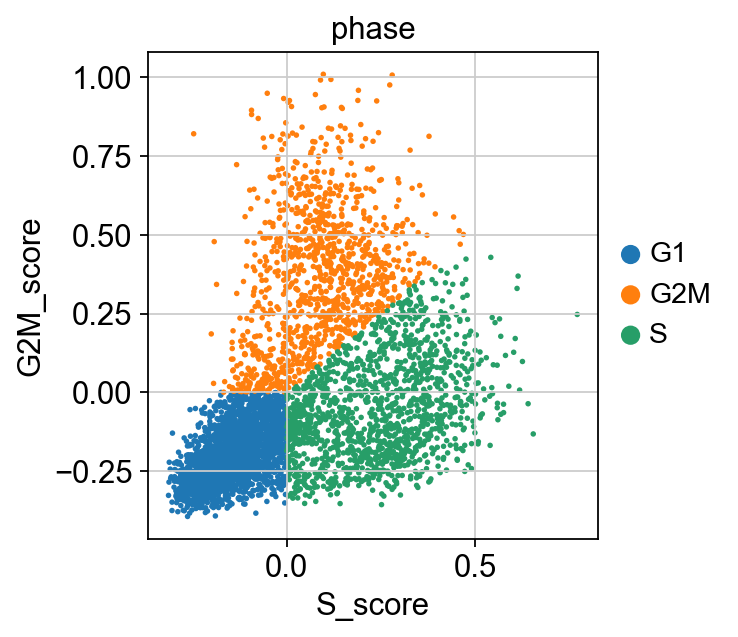

In [18]:
cc_genes=pd.read_csv("./analysis_info/regev_lab_cell_cycle_genes.txt")
s_genes=cc_genes[:46]
g2m_genes=cc_genes[47:]
s_genes.columns=['genes']
g2m_genes.columns=['genes']
sc.tl.score_genes_cell_cycle(adata, s_genes.genes, g2m_genes.genes)
sc.pl.scatter(adata, x='S_score', y='G2M_score', color='phase')

In [19]:
adata.raw = adata

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

In [21]:
# Remove TCR chains for clustering analysis
adata=adata[:,adata.var_names[~np.logical_or(adata.var_names.str.contains('TRB'),
                               adata.var_names.str.contains('TRA'))]]

## Principal component analysis and neighborhood graph

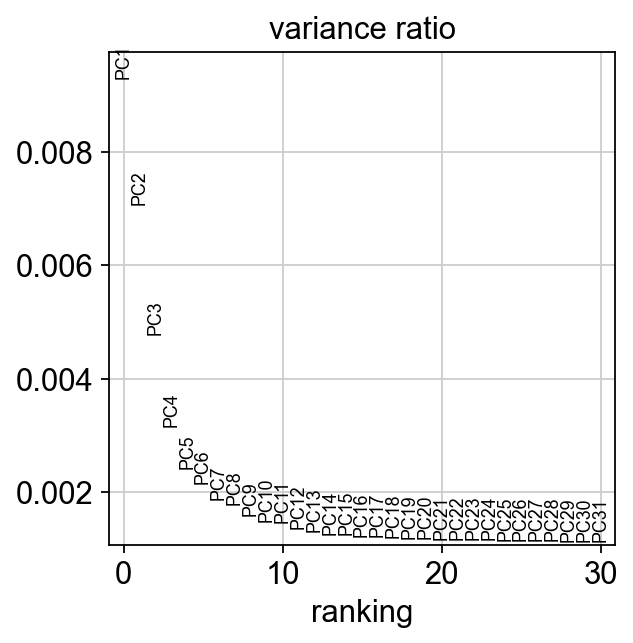

In [22]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

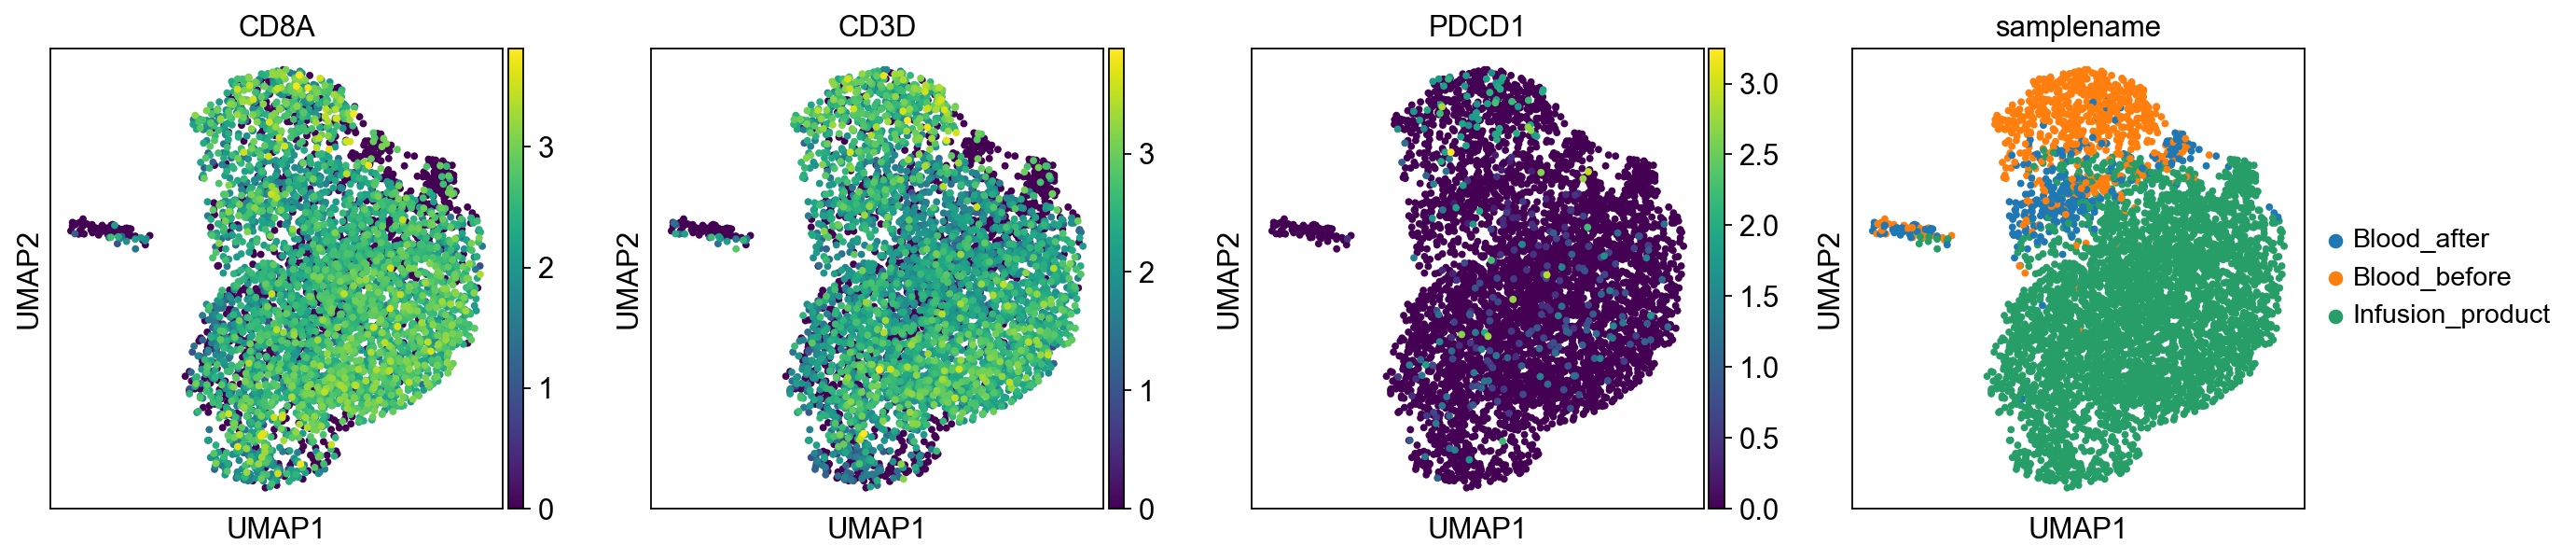

In [23]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=6)
sc.tl.umap(adata, min_dist=0.7)
sc.pl.umap(adata, color=['CD8A', 'CD3D','PDCD1','samplename'],s=50)

## Clustering the neighborhood graph

In [24]:
from sklearn.metrics import silhouette_score
def titrate_leiden_resolution(adata):
    res_array=list(np.round(np.linspace(.1, 2, 20),1))
    silhoutte_list=list()
    sc.settings.verbosity = 1
    for i,res in enumerate(res_array):
        sc.tl.leiden(adata, resolution=res)
        if adata.obs.leiden.unique().shape[0]>2:
            silhoutte_list.append(silhouette_score(adata.obsm['X_umap'],
                    adata.obs[f'leiden'],
                    metric='euclidean'))
        else:
            silhoutte_list.append(np.nan)
        print(str(np.round(((i+1)/len(res_array))*100,1))+"%", end="\r", flush=True)
    sns.lineplot(res_array, silhoutte_list, color='black', markers='o')

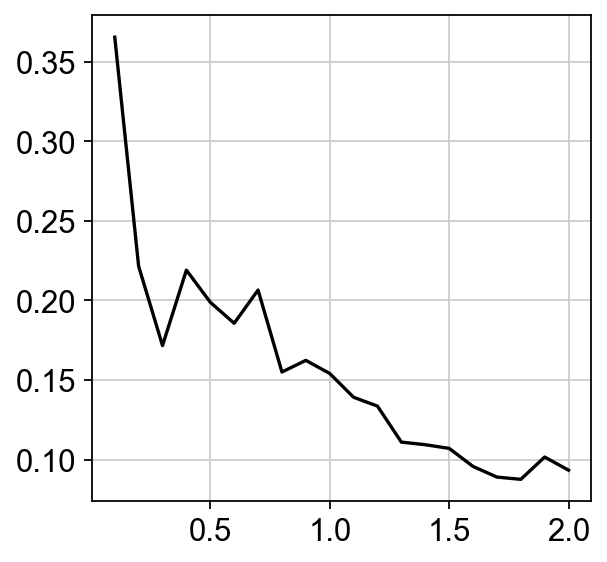

In [25]:
titrate_leiden_resolution(adata)

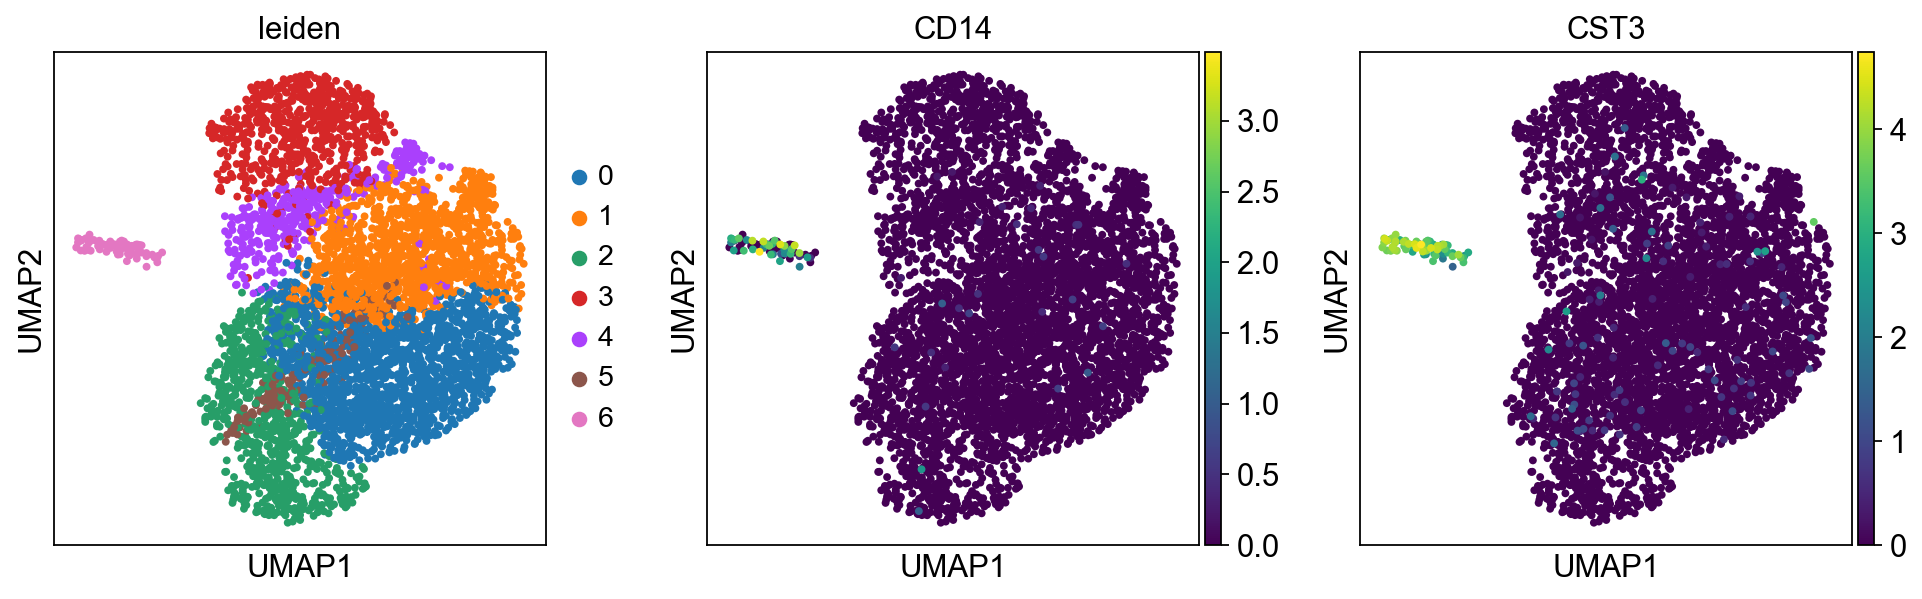

In [33]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=['leiden','CD14','CST3'], save='_leiden.pdf', s=50)

{'mainplot_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b09c8505c0>,
 'group_extra_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b0953a1470>,
 'gene_group_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b095fbf278>,
 'size_legend_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b098fca208>,
 'color_legend_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1b0953e1e80>}

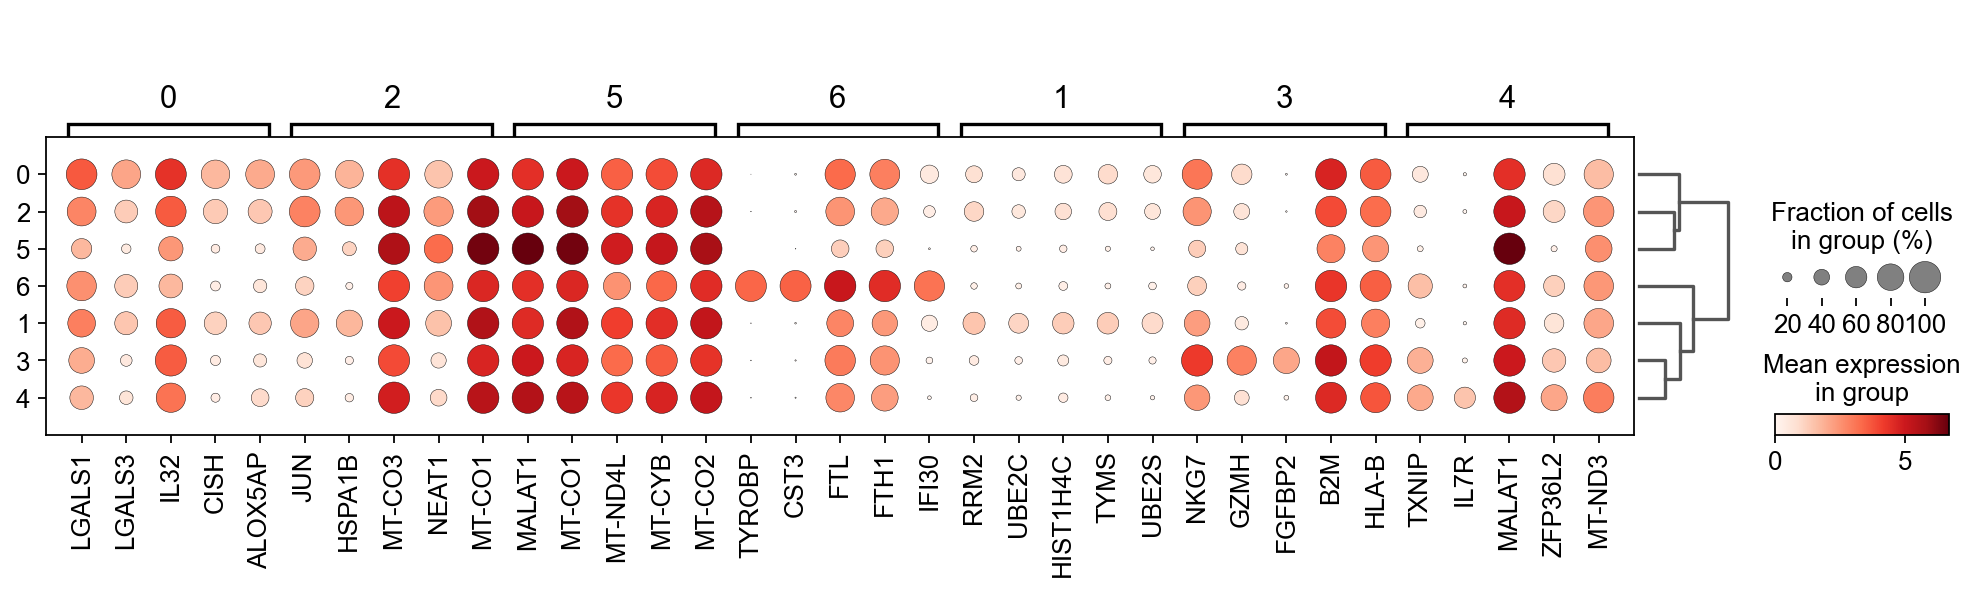

In [27]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=True, method='t-test')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, show=False)

# TCR analysis scirpy

In [28]:
adata_TCR=ir.io.read_10x_vdj('./VDJ/outs/all_contig_annotations.csv')

KeyboardInterrupt: 

In [ ]:
ir.pp.merge_with_tcr(adata, adata_TCR)

In [ ]:
ir.tl.chain_pairing(adata)
ir.pl.group_abundance(adata, groupby="samplename", target_col="chain_pairing")

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig.tight_layout(w_pad=7)
sc.pl.umap(adata, color="chain_pairing", ax=ax[0], show=False, s=40, groups=adata.obs.chain_pairing[adata.obs.chain_pairing!='No TCR'].unique().tolist())
sc.pl.umap(adata, color="has_tcr", palette=['gray','red'], ax=ax[1], show=False, s=40, groups="True")

In [ ]:
print('Unique CDR3 alpha: '+str(adata.obs.TRA_1_cdr3.append(adata.obs.TRA_1_cdr3).nunique()))
print('Unique CDR3 beta: '+str(adata.obs.TRB_1_cdr3.append(adata.obs.TRB_1_cdr3).nunique()))

In [ ]:
ir.pp.tcr_neighbors(adata, receptor_arms="all", dual_tcr="all")
ir.tl.define_clonotypes(adata)

In [ ]:
ir.tl.clonotype_network(adata, layout='fr', min_size=2)
ir.pl.clonotype_network(adata, color=["clonotype","samplename","clonotype_size"], legend_loc="none", color_map="coolwarm", panel_size=(6, 6), size=30)

## Manually annotate clonotypes with secondary chains

In [ ]:
additional_chain_clones=adata[np.logical_and(adata.obs.chain_pairing.isin(['Extra beta', 'Extra alpha']),
                                            adata.obs.clonotype_size>1)].obs.clonotype.unique().tolist()
additional_chain_clones=additional_chain_clones+['2','4','5','13','14','23','49','74','184','471']

In [ ]:
already_plotted=[]
for j,clone in enumerate(additional_chain_clones):
    candidates=adata.obs[(adata.obs.TRB_1_cdr3.isin(adata[adata.obs.clonotype==clone].obs.TRB_1_cdr3.unique().tolist()))&(adata.obs.TRA_1_cdr3.isin(adata[adata.obs.clonotype==clone].obs.TRA_1_cdr3.unique().tolist()))].clonotype.unique()
    candidates=adata.obs[adata.obs.clonotype.isin(candidates)&(adata.obs.clonotype_size>3)].clonotype.unique().tolist()
    if len(candidates)!=0:
        biggest_candidate=adata[adata.obs.clonotype.isin(candidates)].obs.groupby('clonotype').agg({'clonotype_size':'mean'}).sort_values('clonotype_size', ascending=False).index[0]
        hue_order=['TRA_'+adata[adata.obs.clonotype==biggest_candidate].obs.TRA_1_cdr3.unique().tolist()[0],'TRB_'+adata[adata.obs.clonotype==biggest_candidate].obs.TRB_1_cdr3.unique().tolist()[0]]
        if adata[adata.obs.clonotype==biggest_candidate].obs.chain_pairing[0]=='Extra alpha':
            hue_order=hue_order+['TRA_'+adata[adata.obs.clonotype==biggest_candidate].obs.TRA_2_cdr3.unique().tolist()[0]]
        if adata[adata.obs.clonotype==biggest_candidate].obs.chain_pairing[0]=='Extra beta':
            hue_order=hue_order+['TRB_'+adata[adata.obs.clonotype==biggest_candidate].obs.TRB_2_cdr3.unique().tolist()[0]]

        clone=biggest_candidate
        candidates=adata.obs[(adata.obs.TRB_1_cdr3.isin(adata[adata.obs.clonotype==clone].obs.TRB_1_cdr3.unique().tolist()))&(adata.obs.TRA_1_cdr3.isin(adata[adata.obs.clonotype==clone].obs.TRA_1_cdr3.unique().tolist()))].clonotype.unique()
        candidates=adata.obs[adata.obs.clonotype.isin(candidates)&(adata.obs.clonotype_size>3)].clonotype.unique().tolist()
        ncols=len(candidates)+1
        if ((clone in already_plotted)==False) & (len(candidates)>1):
            fig,ax=plt.subplots(ncols=ncols, figsize=(len(candidates)*3,3))
            fig.tight_layout(w_pad=2, h_pad=10)
            fig.suptitle('Potential candidates beloning to clonotype '+clone, y=1.1)
            for i, clonotype in enumerate(candidates):
                CDR3s=('TRB_'+adata.obs[adata.obs.clonotype==clonotype]['TRB_1_cdr3'].astype(str)).tolist()+ \
                ('TRB_'+adata.obs[adata.obs.clonotype==clonotype]['TRB_2_cdr3'].astype(str)).tolist()+ \
                ('TRA_'+adata.obs[adata.obs.clonotype==clonotype]['TRA_1_cdr3'].astype(str)).tolist()+ \
                ('TRA_'+adata.obs[adata.obs.clonotype==clonotype]['TRA_2_cdr3'].astype(str)).tolist()

                expression=adata.obs[adata.obs.clonotype==clonotype]['TRB_1_expr'].tolist()+ \
                adata.obs[adata.obs.clonotype==clonotype]['TRB_2_expr'].tolist()+ \
                adata.obs[adata.obs.clonotype==clonotype]['TRA_1_expr'].tolist()+ \
                adata.obs[adata.obs.clonotype==clonotype]['TRA_2_expr'].tolist()

                df_plot=pd.DataFrame([CDR3s,expression]).T
                df_plot.columns=['sequence','expression']
                df_plot=df_plot[~df_plot.sequence.isin(['TRA_None','TRB_None'])]
                df_plot.expression=df_plot.expression.astype(int)
                order=df_plot.groupby('sequence').median().sort_values('expression', ascending=False).index.tolist()
                sns.boxplot(data=df_plot, x='sequence', y='expression',ax=ax.reshape(-1)[i], hue='sequence', hue_order=hue_order,fliersize=0, whis=[0, 100], order=order, dodge=False)
                sns.stripplot(data=df_plot, x='sequence', y='expression',ax=ax.reshape(-1)[i], edgecolor='white', linewidth=0.4, order=order, color='black')
                ax.reshape(-1)[i].set_xticklabels(ax.reshape(-1)[i].get_xticklabels(),rotation=90, size=10)
                ax.reshape(-1)[i].set_title(clonotype)
                ax.reshape(-1)[i].set_xlabel('')
                ax.reshape(-1)[i].get_legend().remove()
            sc.pl.umap(adata, color='clonotype', groups=candidates, s=50, show=False, ax=ax.reshape(-1)[i+1])
            plt.savefig('./clonotype_annotation/clonotypes_candidates_belonging_to_'+clone+'.pdf', bbox_inches='tight')
            plt.show()
    already_plotted=already_plotted+[clone]

In [ ]:
adata.obs['clonotype_group']=adata.obs['clonotype']
adata.obs['clonotype_group_size']=adata.obs['clonotype_size']

In [ ]:
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['2','16','565'])]='2'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='2']=sum(adata.obs[adata.obs.clonotype.isin(['2','16','565'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['4','68','113','828'])]='4'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='4']=sum(adata.obs[adata.obs.clonotype.isin(['4','68','113','828'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['5','12','22','240'])]='5'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='5']=sum(adata.obs[adata.obs.clonotype.isin(['5','12','22','240'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['13','148'])]='13'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='13']=sum(adata.obs[adata.obs.clonotype.isin(['13','148'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['14','78','150','287','371','1738'])]='14'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='14']=sum(adata.obs[adata.obs.clonotype.isin(['14','78','150','287','371','1738'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['23','231','345','585'])]='23'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='23']=sum(adata.obs[adata.obs.clonotype.isin(['23','231','345','585'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['49','86','292'])]='49'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='49']=sum(adata.obs[adata.obs.clonotype.isin(['49','86','292'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['50','74','133','498'])]='74'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='74']=sum(adata.obs[adata.obs.clonotype.isin(['50','74','133','498'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['471','484'])]='471'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='471']=sum(adata.obs[adata.obs.clonotype.isin(['471','484'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())
adata.obs['clonotype_group'][adata.obs.clonotype.isin(['560','21'])]='560'
adata.obs['clonotype_group_size'][adata.obs.clonotype_group=='560']=sum(adata.obs[adata.obs.clonotype.isin(['560','21'])].groupby('clonotype')['clonotype_size'].agg('first').fillna(0).unique().tolist())

In [ ]:
adata.obs['clonotype_old']=adata.obs['clonotype']
adata.obs['clonotype_size_old']=adata.obs['clonotype_size']
adata.obs['clonotype']=adata.obs['clonotype_group']
adata.obs['clonotype_size']=adata.obs['clonotype_group_size']

In [ ]:
adata_infusion = adata[adata.obs['samplename']=='Infusion_product',:]
adata_blood_before = adata[adata.obs['samplename']=='Blood_before',:]
adata_blood_after = adata[adata.obs['samplename']=='Blood_after',:]

single_donor_adatas=[adata_infusion,adata_blood_before,adata_blood_after]
single_donor_adatas_names=['Infusion_product','Blood_before','Blood_after']

In [ ]:
ir.tl.clonal_expansion(adata, clip_at=1500)
adata.obs['clonal_expansion']=adata.obs['clonal_expansion'].astype(int)
ir.pl.clonal_expansion(adata, "samplename")

In [ ]:
clonotypes_re_expression=['2','4','5','13','14','23','49','74','184','471']

In [ ]:
clonotypes=adata[np.logical_and(np.logical_and(adata.obs.clonotype.isin(single_donor_adatas[0].obs.clonotype),
                                    adata.obs.clonotype.isin(single_donor_adatas[1].obs.clonotype)),
                     adata.obs.clonotype.isin(single_donor_adatas[2].obs.clonotype))].obs['clonotype'].unique()

In [ ]:
sc.pl.umap(adata, color=['HAVCR2','PDCD1','LAG3','EOMES','CD101','CD38','TIGIT','exhaustion_score'],vmin=0,s=100)

In [ ]:
df=adata.obs

In [ ]:
df['PD1']=[x[0] for x in adata.raw[:,'PDCD1'].X.todense().tolist()]
df['CD39']=[x[0] for x in adata.raw[:,'ENTPD1'].X.todense().tolist()]
df['CX3CR1']=[x[0] for x in adata.raw[:,'CX3CR1'].X.todense().tolist()]
df['NKG2D']=[x[0] for x in adata.raw[:,'KLRK1'].X.todense().tolist()]
df['GZMK']=[x[0] for x in adata.raw[:,'GZMK'].X.todense().tolist()]
df['PRF1']=[x[0] for x in adata.raw[:,'PRF1'].X.todense().tolist()]

In [ ]:
adata.obs['PD1']=[x[0] for x in adata.raw[:,'PDCD1'].X.todense().tolist()]
adata.obs['CD39']=[x[0] for x in adata.raw[:,'ENTPD1'].X.todense().tolist()]
adata.obs['CX3CR1']=[x[0] for x in adata.raw[:,'CX3CR1'].X.todense().tolist()]
adata.obs['NKG2D']=[x[0] for x in adata.raw[:,'KLRK1'].X.todense().tolist()]
adata.obs['GZMK']=[x[0] for x in adata.raw[:,'GZMK'].X.todense().tolist()]
adata.obs['PRF1']=[x[0] for x in adata.raw[:,'PRF1'].X.todense().tolist()]

In [ ]:
df=df.sort_values('clonotype_size',ascending=False)
df_plot=df[df.clonotype_size>2]
df_plot['size_infusion']=0
df_plot['size_blood_before']=0
df_plot['size_blood_after']=0

df_plot['frq_PD1_infusion']=0
df_plot['frq_PD1_blood_before']=0
df_plot['frq_PD1_blood_after']=0

In [ ]:
for samplename in adata.obs.samplename.unique().tolist():
    adata.obs['size_'+samplename]=0
    adata.obs['frq_PD1_'+samplename]=0
    adata.obs['PD1_'+samplename]=0
    adata.obs['activation_score_'+samplename]=0
    adata.obs['predysfunctional_score_'+samplename]=0
    adata.obs['dysfunctional_score_'+samplename]=0
    adata.obs['cytotox_score_'+samplename]=0
    adata.obs['cytotoxic_activation_'+samplename]=0
    adata.obs['naive_like_state_'+samplename]=0
    adata.obs['cytokine_activation_'+samplename]=0

for i, clonotype in enumerate(adata.obs.clonotype.unique()):
    for samplename in adata.obs.samplename.unique().tolist():
        adata.obs['size_'+samplename][adata.obs.clonotype==clonotype]=adata.obs[adata.obs.clonotype==clonotype].samplename.value_counts()[samplename]
        
        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            adata.obs['frq_PD1_'+samplename][adata.obs.clonotype==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100
            
        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            adata.obs['PD1_'+samplename][adata.obs.clonotype==clonotype]=df_temp.PD1.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.activation_score, columns=['activation_score'])
        if df_temp.shape[0]!=0:
            adata.obs['activation_score_'+samplename][adata.obs.clonotype==clonotype]=df_temp.activation_score.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.predysfunctional_state, columns=['predysfunctional_state'])
        if df_temp.shape[0]!=0:
            adata.obs['predysfunctional_score_'+samplename][adata.obs.clonotype==clonotype]=df_temp.predysfunctional_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.dysfunctional_state, columns=['dysfunctional_state'])
        if df_temp.shape[0]!=0:
            adata.obs['dysfunctional_score_'+samplename][adata.obs.clonotype==clonotype]=df_temp.dysfunctional_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.cytotoxic_state, columns=['cytotoxic_state'])
        if df_temp.shape[0]!=0:
            adata.obs['cytotox_score_'+samplename][adata.obs.clonotype==clonotype]=df_temp.cytotoxic_state.mean()
            
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.cytotoxic_activation, columns=['cytotoxic_activation'])
        if df_temp.shape[0]!=0:
            adata.obs['cytotoxic_activation_'+samplename][adata.obs.clonotype==clonotype]=df_temp.cytotoxic_activation.mean()
            
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.naive_like_state, columns=['naive_like_state'])
        if df_temp.shape[0]!=0:
            adata.obs['naive_like_state_'+samplename][adata.obs.clonotype==clonotype]=df_temp.naive_like_state.mean()
        
        df_temp=pd.DataFrame(adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename==samplename)].obs.cytokine_activation, columns=['cytokine_activation'])
        if df_temp.shape[0]!=0:
            adata.obs['cytokine_activation_'+samplename][adata.obs.clonotype==clonotype]=df_temp.cytokine_activation.mean()
   
    print(str(np.round(((i+1)/len(adata.obs.clonotype.unique()))*100,1))+"%", end="\r", flush=True)

In [ ]:
calculate_size = False

In [ ]:
if calculate_size == True:
    for i, clonotype in enumerate(df_plot.clonotype.unique()):
        df_plot['size_infusion'][df_plot.clonotype==clonotype]=df_plot[df_plot.clonotype==clonotype].samplename.value_counts()['Infusion_product']
        df_plot['size_blood_before'][df_plot.clonotype==clonotype]=df_plot[df_plot.clonotype==clonotype].samplename.value_counts()['Blood_before']
        df_plot['size_blood_after'][df_plot.clonotype==clonotype]=df_plot[df_plot.clonotype==clonotype].samplename.value_counts()['Blood_after']

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename=='Infusion_product'),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_infusion'][df_plot.clonotype==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename=='Blood_before'),'PDCD1'].X], columns=['PD1'])    
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_blood_before'][df_plot.clonotype==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        df_temp=pd.DataFrame([x[0] for x in adata[np.logical_and(adata.obs.clonotype==clonotype,adata.obs.samplename=='Blood_after'),'PDCD1'].X], columns=['PD1'])
        if df_temp.shape[0]!=0:
            df_plot['frq_PD1_blood_after'][df_plot.clonotype==clonotype]=df_temp[df_temp.PD1>0].shape[0]/df_temp.shape[0]*100

        print(str(np.round(((i+1)/len(df_plot.clonotype.unique()))*100,1))+"%", end="\r", flush=True)
    df_plot.to_csv('df_plot.csv')
if calculate_size == False:
    df_plot=pd.read_csv('df_plot.csv', index_col=0)

In [ ]:
fig,ax=plt.subplots(nrows=2, figsize=(50,10))

order=df_plot.sort_values('clonotype_size',ascending=False).clonotype.unique().tolist()

x=df_plot.clonotype.tolist()
y1=df_plot.size_blood_after+df_plot.size_blood_before+df_plot.size_infusion
y2=df_plot.size_blood_before+df_plot.size_infusion
y3=df_plot.size_infusion
hue=df_plot.samplename
sns.barplot(x=x,y=y1, color='#1f77b4', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y2, color='#ff7f0e', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y3, color='#279e68', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
ax[0].set_ylabel('size')

x=df_plot.clonotype.tolist()
y=df_plot.PD1.tolist()
hue=df_plot.samplename
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[1], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[1], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True)
ax[1].set_ylabel('PD1 expression')

fig.savefig('./figures/dotplot.pdf', dpi=300)

In [ ]:
sc.pl.umap(adata, color=['activation_score','exhaustion_score','ENTPD1','KLRK1','CXCR3'])

In [ ]:
fig,ax=plt.subplots(nrows=9, figsize=(25,50))
order=df_plot.sort_values('clonotype_size',ascending=False).clonotype.unique().tolist()

x=df_plot.clonotype.tolist()
y1=df_plot.size_blood_after
y2=df_plot.size_blood_before
y3=df_plot.size_infusion
hue=df_plot.samplename
sns.barplot(x=x,y=y1, color='#1f77b4', ax=ax[1], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y2, color='#ff7f0e', ax=ax[0], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y3, color='#279e68', ax=ax[2], order=order, edgecolor='black', linewidth=0.2)
ax[1].set_ylabel('size_blood_after')
ax[0].set_ylabel('size_blood_before')
ax[2].set_ylabel('size_infusion')

y=df_plot.PD1.tolist()
hue=df_plot.samplename
hue_order=['Blood_before','Blood_after','Infusion_product']
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[3], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[3], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True,
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[3].set_ylabel('PD1 expression')

y=df_plot.activation_score.tolist()
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[4], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[4], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True, 
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[4].set_ylabel('activation_score')

y=df_plot.exhaustion_score.tolist()
sns.boxplot(x=x,y=y, color='lightgray',fliersize=0, whis=[0, 100], ax=ax[5], order=order, linewidth=0.2,)
sns.stripplot(x=x,y=y, hue=hue, ax=ax[5], order=order, edgecolor='black', linewidth=0.2, size=7, dodge=True, 
              palette=['#ff7f0e','#1f77b4','#279e68'], hue_order=hue_order)
ax[5].set_ylabel('exhaustion_score')

y4=df_plot.frq_PD1_blood_after
y5=df_plot.frq_PD1_blood_before
y6=df_plot.frq_PD1_infusion
hue=df_plot.samplename
sns.barplot(x=x,y=y4, color='#1f77b4', ax=ax[7], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y5, color='#ff7f0e', ax=ax[6], order=order, edgecolor='black', linewidth=0.2)
sns.barplot(x=x,y=y6, color='#279e68', ax=ax[8], order=order, edgecolor='black', linewidth=0.2)
ax[7].set_ylabel('%PD1_blood_after')
ax[6].set_ylabel('%PD1_blood_before')
ax[8].set_ylabel('%PD1_infusion')

fig.savefig('./figures/dotplot_single_size_PD1_activation.pdf', dpi=300)

In [ ]:
fig, ax=plt.subplots(nrows=2, ncols=5, figsize=(20,8))
fig.tight_layout(w_pad=2)
for i, clonotype in enumerate(clonotypes_re_expression):
    sc.pl.umap(adata, legend_loc='none', frameon=False, ax=ax.reshape(-1)[i], show=False, s=50)
    sc.pl.umap(adata, color='clonotype', groups=clonotype, legend_fontsize=8, 
               legend_loc='none', title=clonotype, add_outline=False, outline_width=(0.2, 0.0),
               frameon=False, ax=ax.reshape(-1)[i], show=False, s=20)
    sc.pl.umap(adata[adata.obs.clonotype==clonotype], color='clonotype', groups=clonotype, legend_fontsize=8, 
               legend_loc='none', title=clonotype, add_outline=True, outline_width=(0.2, 0.0),
               frameon=False, ax=ax.reshape(-1)[i], show=False, s=20)

In [ ]:
sequence_data=pd.read_csv('./VDJ/outs/airr_rearrangement.tsv', sep='\t')

In [ ]:
sequence_data_4=sequence_data[sequence_data.cell_id.isin(adata[adata.obs.clonotype=='4'].obs_names)]
sequence_data_4.to_excel('sequence_data_clone_4_all.xlsx')
sequence_data_4[sequence_data.v_call=='TRAV19'].to_excel('sequence_data_clone_4_TRAV19.xlsx')

sequence_data_113=sequence_data[sequence_data.cell_id.isin(adata[adata.obs.clonotype=='113'].obs_names)]
sequence_data_113.to_excel('sequence_data_clone_113_all.xlsx')
sequence_data_113[sequence_data.v_call=='TRAV19'].to_excel('sequence_data_clone_113_TRAV19.xlsx')

sequence_data_471=sequence_data[sequence_data.cell_id.isin(adata[adata.obs.clonotype=='471'].obs_names)]
sequence_data_471.to_excel('sequence_data_clone_471_all.xlsx')
sequence_data_471[sequence_data.v_call=='TRAV19'].to_excel('sequence_data_clone_471_TRAV19.xlsx')

In [ ]:
adata.obs.clonotype[adata.obs.clonotype=='16']='2'
adata.obs.clonotype[adata.obs.clonotype=='78']='14'
adata.obs.clonotype[adata.obs.clonotype=='113']='4'

adata.obs.clonotype_group[adata.obs.clonotype=='16']='2'
adata.obs.clonotype_group[adata.obs.clonotype=='78']='14'
adata.obs.clonotype_group[adata.obs.clonotype=='113']='4'

In [ ]:
adata.write('adata_figures.h5ad')